# Amazon Stock Prices Prediction

In [7]:
# Importing drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
# Importing Plot Module
import plotly
import plotly.offline as py
import plotly.io as pio
import plotly.graph_objs as go
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [9]:
# Importing Libraries
from pandas_datareader import data
import math
import numpy as np
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import tensorflow.compat.v1 as tf 
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader as web
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [10]:
# Working with plotly offline
from plotly.offline import plot, iplot
plotly.offline.init_notebook_mode(connected=True)

In [11]:
# Setting renderers
pio.renderers
pio.renderers.default = 'colab'

## Get Data

In [55]:
amzn = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Stock Price Prediction/data_csv/AMZN-051497-070620.csv')
amzn.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5818,2020-06-29,2690.010010,2696.800049,2630.080078,2680.379883,2680.379883,4223400
5819,2020-06-30,2685.070068,2769.629883,2675.030029,2758.820068,2758.820068,3769700
5820,2020-07-01,2757.989990,2895.000000,2754.000000,2878.699951,2878.699951,6363400
5821,2020-07-02,2912.010010,2955.560059,2871.100098,2890.300049,2890.300049,6593400
5822,2020-07-06,2934.969971,3059.879883,2930.000000,3057.040039,3057.040039,6858500


## Plot Close Price History

In [56]:
close = [go.Scatter(x= amzn.Date,
                    y= amzn.Close)]
py.iplot(close)

## Improving Visualization

In [57]:
data = close
interactive_layout = dict(
                          title= 'Amazon Close Prices',
                          title_x= 0.5,
                          xaxis= dict(
                              rangeselector= dict(
                                                  buttons= list([
                                                                 dict(count=1,
                                                                      label= '1m',
                                                                      step= 'month',
                                                                      stepmode= 'backward'),
                                                                 dict(count=3,
                                                                     label= '3m',
                                                                     step='month',
                                                                      stepmode= 'backward'),
                                                                 dict(count=6,
                                                                      label= '6m',
                                                                      step='month',
                                                                      stepmode= 'backward'),
                                                                 dict(step='all')
                                                                 ])
                                                  ),
                              rangeslider=dict(visible=True),
                              type='date'
                                      )
                           )
fig = dict(data= data, layout=interactive_layout)
py.iplot(fig)

## Select recent period

In [58]:
period = 252*8
df = amzn.iloc[-period:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5818,2020-06-29,2690.010010,2696.800049,2630.080078,2680.379883,2680.379883,4223400
5819,2020-06-30,2685.070068,2769.629883,2675.030029,2758.820068,2758.820068,3769700
5820,2020-07-01,2757.989990,2895.000000,2754.000000,2878.699951,2878.699951,6363400
5821,2020-07-02,2912.010010,2955.560059,2871.100098,2890.300049,2890.300049,6593400
5822,2020-07-06,2934.969971,3059.879883,2930.000000,3057.040039,3057.040039,6858500


## Creating new DF with the column Close


In [59]:
# Creating DF with colum 'Close'
data = df.filter(['Close'])

# Covert DF to a numpy array
dataset = data.values

# Get the number of rows to train the module
training_data_len = math.ceil(len(dataset)*0.8)

training_data_len

1613

## Data Normalization

In [60]:
# Scale the Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00457124],
       [0.00491259],
       [0.00498649],
       ...,
       [0.93724132],
       [0.94132345],
       [1.        ]])

## Train Data

In [61]:
# Creating training dataset
# Creating the scaled trainig data set
train_data = scaled_data[0:training_data_len, :]

# Split the data between x and y train data sets
x_train = []
y_train = []

# Separete first 60 items for x_train and the 61 for y_train
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [62]:
train_data

array([[0.00457124],
       [0.00491259],
       [0.00498649],
       ...,
       [0.45795796],
       [0.45279554],
       [0.48069098]])

### Convert to a numpy array

In [63]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

### Reshape Data

In [64]:
# Reshape de Data for 3 dimensions, once LSTM needs it
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))    # (num of samples/rows, time steps, features)
x_train.shape

(1553, 60, 1)

### Build LSTM model

In [65]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [66]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

### Train model

In [67]:
# Train Model
model.fit(x_train, y_train, 
          batch_size=1,    # batch size: total number of training examples present in a single batch 
          epochs=1)        # epochs: number of iterations when an entire dataset is passed foward and backward through a neural network


    

Epoch 1/1
1553/1553 [==============================] - 53s 34ms/step - loss: 6.9693e-04


## Test Data

In [68]:
# Creating Test Data set
# Creating a new array containing scaled values from index 2519 to 2479
test_data = scaled_data[training_data_len -60 : , :]
#Creating the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len: , :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60 : i, 0])

### Covert to a numpy array

In [69]:
#Convert data to numpy array
x_test = np.array(x_test)

### Rashape data

In [70]:
# Reshaping to 3 dimension
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))    # (num of samples/rows, time steps, features)
x_test.shape

(403, 60, 1)

### Get models prediction price values

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions

### Get the Root Mean Squared Error

In [72]:
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

1.3029073148069168

## Plot Result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



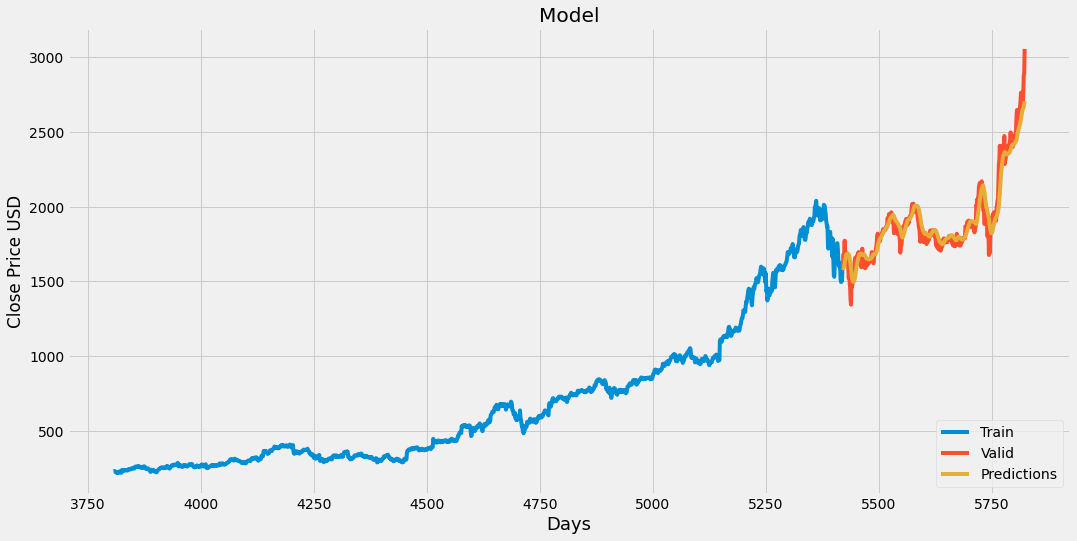

In [73]:
# Plot data
train = data[ : training_data_len]
valid = data[training_data_len : ]
valid['Predictions'] = predictions
# Visualize data
plt.figure(figsize= (16,8))
plt.title('Model')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Close Price USD')

# Selecting Data
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Valid','Predictions'], loc='lower right')
plt.show()

## Predicting a New day

In [74]:
# Get quote
amazon_quote = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Stock Price Prediction/data_csv/TSLA-062810-070120.csv')
#Create DF
new_df = amazon_quote.filter(['Close'])
# Get the last 60 days closing price values and covert the df to an array
last_60_days = new_df[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = []
# Append the past 60 days
X_test.append(last_60_days_scaled)
# Covert X_test to a numpy array
X_test = np.array(X_test)
# Rashape Test Data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predict scaled price
pred_price = model.predict(X_test)
# Undoing Scaling
pred_price = scaler.inverse_transform(pred_price)
pred_price

array([[1036.5581]], dtype=float32)

## Improving Prediction with LSTM tools

Trying to adapt the application given in [this tutorial](https://www.datacamp.com/community/tutorials/lstm-python-stock-market?utm_source=adwords_ppc&utm_campaignid=10267161064&utm_adgroupid=102842301792&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377092&utm_targetid=dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001552&gclid=CjwKCAjwxev3BRBBEiwAiB_PWIL2Y54jNswJt7E7MZjtN_RjrSwlpvRdGKecI24pt5fczGGS026fwRoCXGEQAvD_BwE) for our example.

In [ ]:
df = amzn 

### Get train and test data

In [76]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0

data = df.filter(['Close'])

# Covert DF to a numpy array
dataset = data.values

# Get the number of rows to train the module
training_data_len = math.ceil(len(dataset)*0.8)

training_data_len

4659

In [77]:
train_data = mid_prices[:training_data_len]
test_data = mid_prices[training_data_len:]

### Covert to a numpy array

In [78]:
# Convert the x_train and y_train to numpy arrays
train_data, test_data = np.array(train_data), np.array(test_data)

### Normalize Data

In [79]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [80]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 500
for di in range(0,2000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [81]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

### Standard Average

In [82]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(training_data_len):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [100]:
window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00282


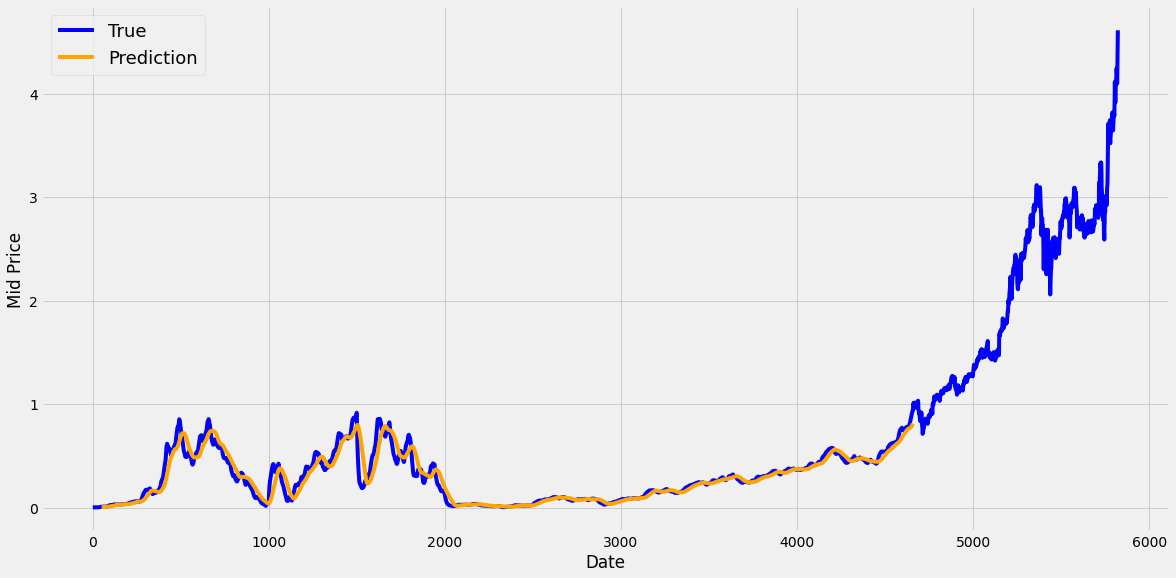

In [101]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### Exponential Moving Average

In [102]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00005


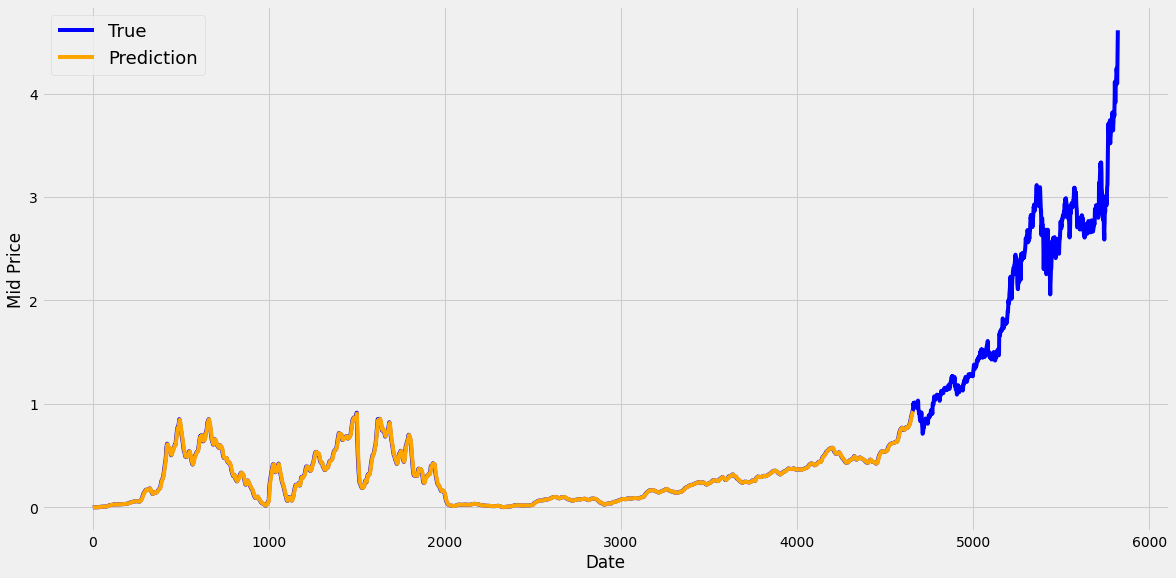

In [103]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### Defining Hyperparameters

In [104]:
tf.compat.v1.disable_eager_execution()

In [128]:
D = 1                              # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 25                # Number of time steps you look into the future.
batch_size = 250                   # Number of samples in a batch
num_nodes = [100,100,75]          # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes)          # number of layers
dropout = 0.2                      # dropout amount

tf.reset_default_graph() # In case you run this multiple times

### Defining Inputs and Outputs

In [129]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

### Define Parameters of the LSTM and Regression layer

In [130]:
lstm_cells = [
    tf.nn.rnn_cell.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.nn.rnn_cell.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]

drop_multi_cell = tf.nn.rnn_cell.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1])
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

### Calculate LSTM output and Feed it to the regression layer

In [131]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.nn.rnn_cell.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of a specific format
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

### Loss Calculation and Optimizer

In [132]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


### Prediction Related Calculations

In [133]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.nn.rnn_cell.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [134]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00079796 0.09718903 0.3726282  0.08377081 0.2433351 ]

	Output: [0.00079796 0.10357909 0.36573347 0.08422985 0.24202985]


Unrolled index 1
	Inputs:  [0.00116204 0.09964796 0.37097913 0.08422985 0.24307996]

	Output: [0.00133879 0.10357909 0.36573347 0.08440714 0.24307996]


Unrolled index 2
	Inputs:  [0.00135006 0.10154747 0.36841476 0.08448766 0.24291015]

	Output: [0.00148754 0.10154747 0.3659268  0.08448766 0.24291015]


Unrolled index 3
	Inputs:  [0.00151429 0.10256724 0.3659268  0.0845434  0.242296  ]

	Output: [0.00128939 0.10256724 0.34928617 0.08311191 0.24173127]


Unrolled index 4
	Inputs:  [0.00148754 0.10357909 0.36573347 0.08433884 0.24202985]

	Output: [0.00133879 0.10374402 0.35481694 0.08234458 0.242598  ]


### Running the LSTM

In [135]:
epochs = 30
valid_summary = 1                                                                 # Interval you make test predictions

n_predict_once = 50                                                               # Number of steps you continously predict for

train_seq_length = train_data.size                                                # Full length of the training data

train_mse_ot = []                                                                 # Accumulate Train losses
test_mse_ot = []                                                                  # Accumulate Test loss
predictions_over_time = []                                                        # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2                                                    # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(training_data_len,training_data_len+204,12).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning:

An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).



Average loss at step 1: 1.674306


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



	Test MSE: 0.34196
	Finished Predictions
Average loss at step 2: 0.248211
	Test MSE: 0.04123
	Finished Predictions
Average loss at step 3: 0.100131
	Test MSE: 0.03404
	Finished Predictions
Average loss at step 4: 0.078050
	Test MSE: 0.06345
	Finished Predictions
Average loss at step 5: 0.051651
	Test MSE: 0.03432
	Finished Predictions
Average loss at step 6: 0.054275
	Test MSE: 0.03215
	Finished Predictions
Average loss at step 7: 0.055902
	Test MSE: 0.02977
	Finished Predictions
Average loss at step 8: 0.065333
	Test MSE: 0.03028
	Finished Predictions
Average loss at step 9: 0.076079
	Test MSE: 0.02850
	Finished Predictions
Average loss at step 10: 0.072274
	Test MSE: 0.02517
	Finished Predictions
Average loss at step 11: 0.062408
	Test MSE: 0.02734
	Finished Predictions
Average loss at step 12: 0.053651
	Test MSE: 0.02744
	Finished Predictions
Average loss at step 13: 0.051235
	Decreasing learning rate by 0.5
	Test MSE: 0.04304
	Finished Predictions
Average loss at step 14: 0.042372


### Plot Predictions

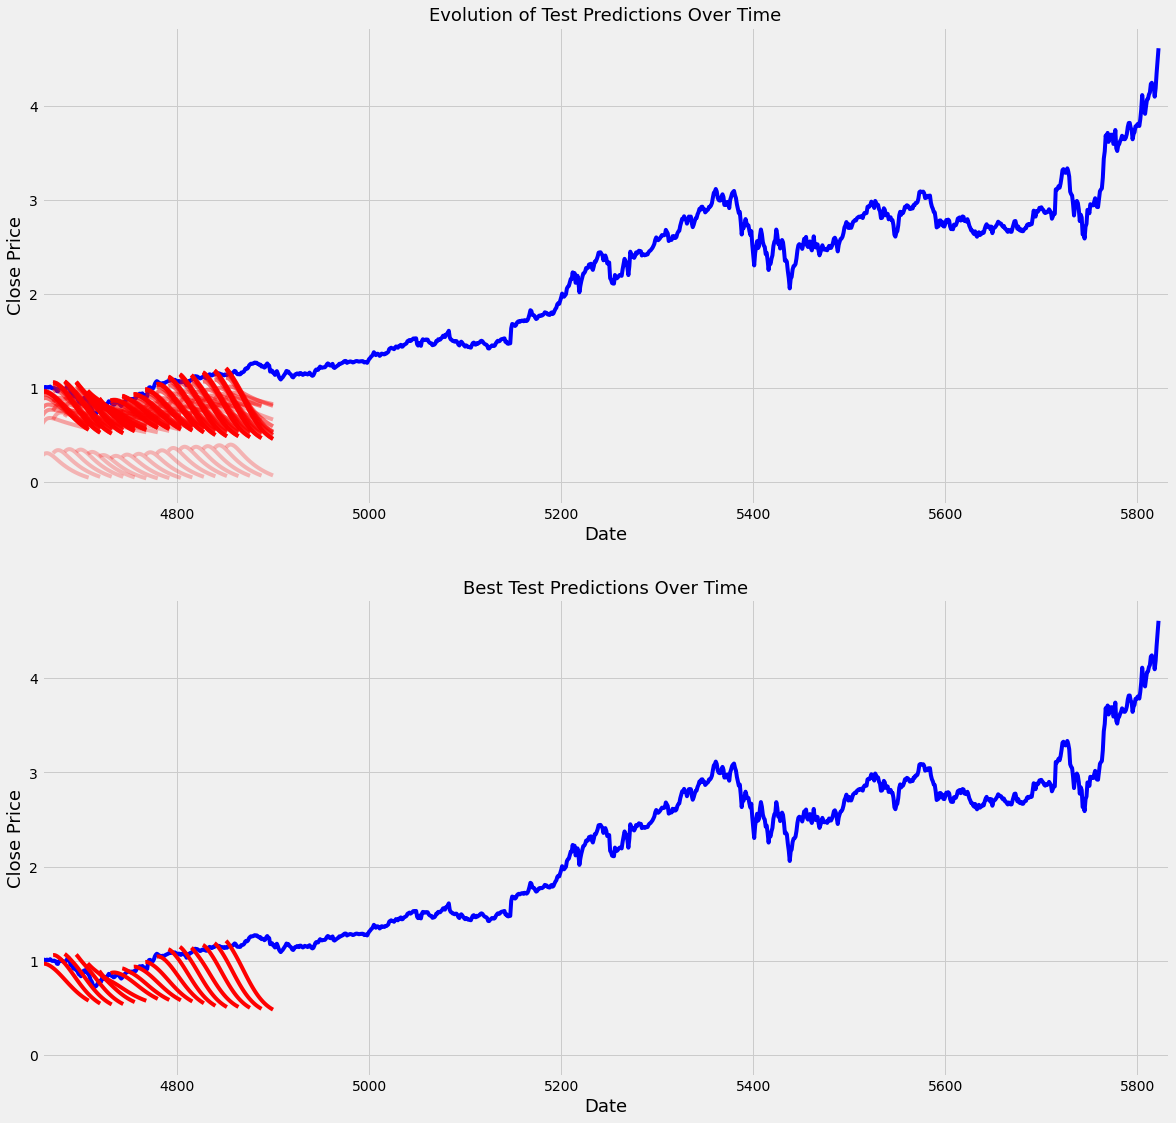

In [136]:
best_prediction_epoch = 23 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.xlim(training_data_len,len(df)+10)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.xlim(training_data_len, len(df)+10)
plt.show()

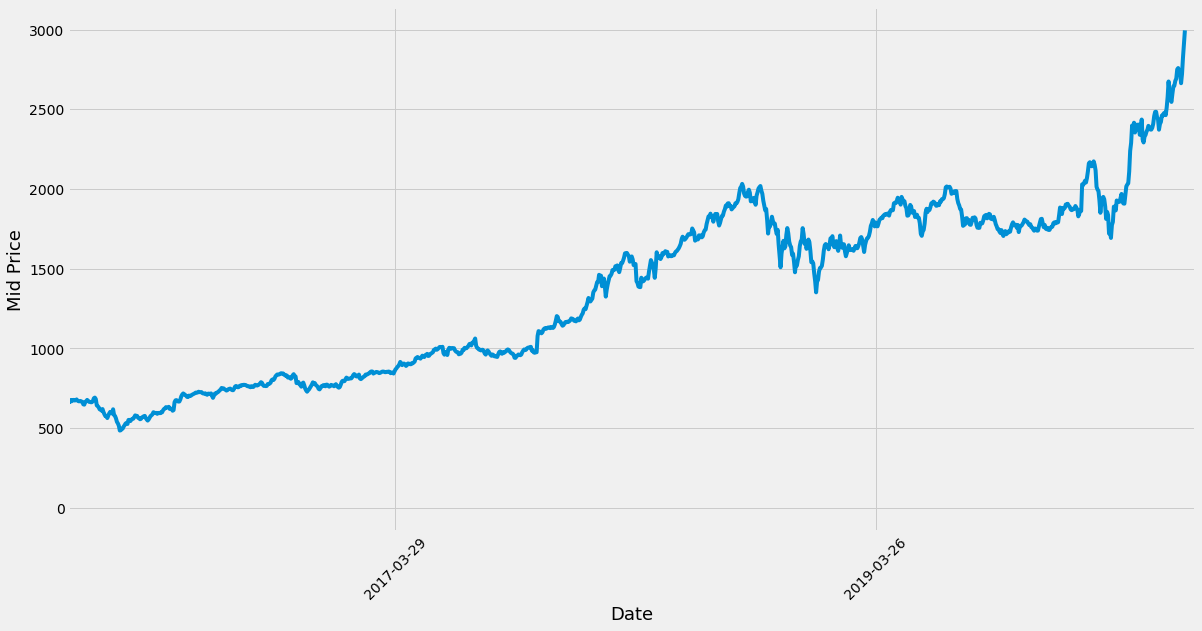

In [137]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(training_data_len, len(df)+10)
plt.show()